In [1]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [2]:
def loadsgy(filename):
  with segyio.open(filename, 'r', iline=5, xline=21) as segyfile:
    segyfile.mmap()
    data = segyio.tools.cube(segyfile)
    ntraces = segyfile.tracecount
    sr = segyio.tools.dt(segyfile)
    nsamples = segyfile.samples.size
    twt = segyfile.samples
    size_mb= data.nbytes/1024**2
    inlines = segyfile.ilines
    crosslines = segyfile.xlines
    header = segyio.tools.wrap(segyfile.text[0])
    return data

In [3]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [4]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [5]:
def load_well(filename):
    well = np.loadtxt(filename, skiprows=15)
    return well

In [6]:
# Load Data
# Relative Impedance
lfr = loadsgy('trace_maths_pimpedance.sgy')
lfr = lfr.transpose(2, 0, 1).reshape(-1, lfr.shape[1])
# Seismic
seis = loadsgy('arbitrary_line.sgy')
seis = seis.transpose(2, 0, 1).reshape(-1, seis.shape[1])
# Amplitude Envelope
env = loadsgy('envelope.sgy')
env = env.transpose(2, 0, 1).reshape(-1, env.shape[1])
# Quadrature
quad = loadsgy('quadrature_al.sgy')
quad = quad.transpose(2, 0, 1).reshape(-1, quad.shape[1])
# Well
y_f21 = load_well('./data/01-F02-1_logs.txt')
y_f32 = load_well('./data/02-F03-2_logs.txt')
y_f34 = load_well('./data/03-F03-4_logs.txt')
y_f61 = load_well('./data/04-F06-1_logs.txt')

In [7]:
# Slicing Data
lfr_f21 = lfr[130:275, 0]
seis_f21 = seis[130:275, 0]
env_f21 = env[130:275, 0]
quad_f21 = quad[130:275, 0]

lfr_f32 = lfr[130:275, 1017]
seis_f32 = seis[130:275, 1017]
env_f32 = env[130:275, 1017]
quad_f32 = quad[130:275, 1017]

lfr_f34 = lfr[130:275, 738]
seis_f34 = seis[130:275, 738]
env_f34 = env[130:275, 738]
quad_f34 = quad[130:275, 738]

lfr_f61 = lfr[130:275, 117]
seis_f61 = seis[130:275, 117]
env_f61 = env[130:275, 117]
quad_f61 = quad[130:275, 117]

y_f21 = y_f21[130:275, 2].reshape(145,1)
y_f32 = y_f32[130:275, 2].reshape(145,1)
y_f34 = y_f34[130:275, 2].reshape(145,1)
y_f61 = y_f61[130:275, 2].reshape(145,1)

In [8]:
# filtering
y_f21 = y_f21.flatten()
y_f32 = y_f32.flatten()
y_f34 = y_f34.flatten()
y_f61 = y_f61.flatten()

y_f21_f = butter_lowpass_filter(y_f21, 70, 1000/4, order=5)
y_f32_f = butter_lowpass_filter(y_f32, 70, 1000/4, order=5)
y_f34_f = butter_lowpass_filter(y_f34, 70, 1000/4, order=5)
y_f61_f = butter_lowpass_filter(y_f61, 70, 1000/4, order=5)

In [9]:
# Selecting Data Training test split
x1 = np.vstack((seis_f21, lfr_f21, env_f21, quad_f21))
x2 = np.vstack((seis_f32, lfr_f32, env_f32, quad_f32))
x1 = x1.T
x2 = x2.T
xtrain = np.vstack((x1, x2))
ytrain = np.hstack((y_f21_f, y_f32_f)).T
ytrain = ytrain.reshape(-1, 1)

In [10]:
# Selecting data blind test
x_bt1 = np.vstack((seis_f34, lfr_f34, env_f34, quad_f34)).T
x_bt2 = np.vstack((seis_f61, lfr_f61, env_f61, quad_f61)).T
y_bt1 = y_f34_f.reshape(-1, 1)
y_bt2 = y_f61_f.reshape(-1, 1)

In [11]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
xscale=scaler_x.fit_transform(xtrain)
yscale=scaler_y.fit_transform(ytrain)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              5000      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                12012     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 17,125
Trainable params: 17,125
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
8/8 [==============================] - 2s 178ms/step - loss: 0.0620 - mse: 0.0620 - mae: 0.2138 - val_loss: 0.0684 - val_mse: 0.0684 - val_mae: 0.2382
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0644 - mse: 0.06

8/8 [==============================] - 0s 6ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0324 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0323
Epoch 47/50
8/8 [==============================] - 0s 5ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0332 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0342
Epoch 48/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0335 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0317
Epoch 49/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0312 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0326
Epoch 50/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0318 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0413


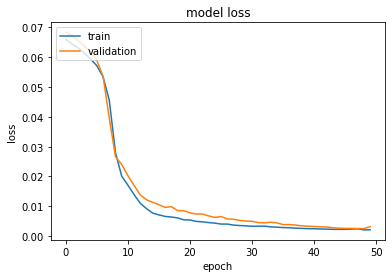

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from keras import initializers

X_train, X_test, y_train, y_test = train_test_split(xscale, yscale, test_size=0.2)
model = Sequential()
model.add(Dense(1000, input_dim=xtrain.shape[1], kernel_initializer='random_normal',
                activation='relu', use_bias = True, bias_initializer = 'zeros'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
history = model.fit(X_train, y_train, epochs=50,validation_data = (X_test,y_test))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

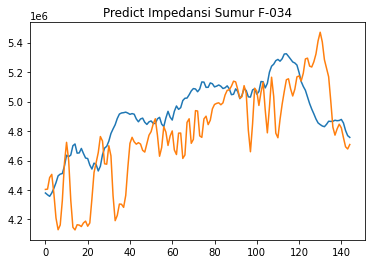

In [13]:
# Blind test Process F034
x_bt1 = scaler_x.transform(x_bt1)
ypred = model.predict(x_bt1)
ypred = scaler_y.inverse_transform(ypred)
plt.figure()
plt.title('Predict Impedansi Sumur F-034')
plt.plot(ypred)
plt.plot(y_bt1)

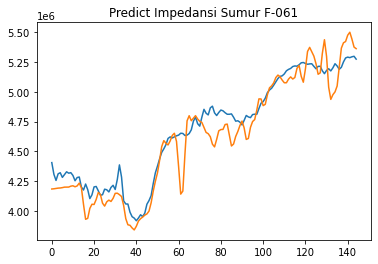

In [14]:
# Blind test Process F061
x_bt2 = scaler_x.transform(x_bt2)
ypred2 = model.predict(x_bt2)
ypred2 = scaler_y.inverse_transform(ypred2)
plt.figure()
plt.title('Predict Impedansi Sumur F-061')
plt.plot(ypred2)
plt.plot(y_bt2)

0.8796042922919773


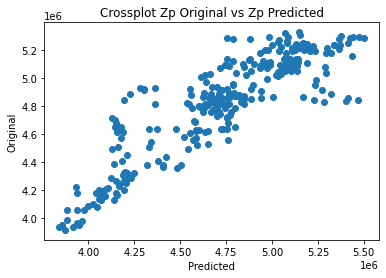

In [15]:
# crossplot
from scipy.stats import pearsonr
x = np.vstack((y_bt1, y_bt2))
y = np.vstack((ypred, ypred2))
plt.figure()
plt.title('Crossplot Zp Original vs Zp Predicted')
plt.xlabel('Predicted')
plt.ylabel('Original')
zx = x.flatten()
zy = y.flatten()
corr,_ = pearsonr(zx, zy)
print(corr)
plt.scatter(x, y)
# plt.legend()

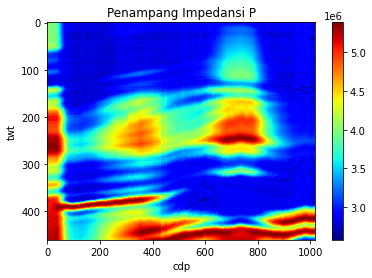

In [16]:
data_all = []

for i in range(seis.shape[1]):
    seis_t = seis[:, i]
    lfr_t = lfr[:, i]
    env_t = env[:, i]
    quad_t = quad[:, i]
    data_all.append(seis_t)
    data_all.append(lfr_t)
    data_all.append(env_t)
    data_all.append(quad_t)
data_all = np.transpose(data_all)
impedansi = []
column = xtrain.shape[1]

for i in range(seis.shape[1]):
    seis_pred = data_all[:, (0+((i+1)-1)*column):(column+((i+1)-1)*column)]
    seis_pred_scale = scaler_x.fit_transform(seis_pred)
    testing = model.predict(seis_pred_scale)
    pred2d = scaler_y.inverse_transform(testing)
    impedansi.append(pred2d)
impedansi = np.array(impedansi)
impedansi = impedansi.transpose(2, 0, 1).reshape(-1, impedansi.shape[1])
impedansi = impedansi.T
plt.figure()
plt.title('Penampang Impedansi P')
plt.imshow(impedansi, aspect='auto', cmap='jet')
plt.xlabel('cdp')
plt.ylabel('twt')
plt.colorbar()
plt.show()